# Провести исследование данных и определить отдельные кластеры. Также выявить точки выбросов и признаки, по которым эти точки обозначились выбросами.

# Метод DBSCAN кластеризация. Данные: Wholesale customers Data Set

Описание:
Данные о клиентах некоторого оптового дистребьютора из Португалии. Здесь приведены денежные расходы за год по нескольким категориям продуктов.
1) FRESH - расходы за год на свежие продукты (непрерывная переменная);
2) MILK - расходны за год на молочные продукты (непрерывная переменная);
3) GROCERY - расходы за год на бакалею (непрерывная переменная);
4) FROZEN - расходы за год на замороженные продукты (непрерывная переменная);
5) DETERGENTS_PAPER - расходы за год на моющие средства и бумажные изделия (непрерывная переменная);
6) DELICATESSEN - расходы за год на деликатесы (непрерывная переменная);
7) CHANNEL - расходы за год на индустрию общественного питания Horeca или розничный канал Retail (категориальная переменная);
8) REGION - регион клиента (категориальная переменная);

In [ ]:
# библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(r"wholesome_customers_data.csv")

In [49]:
df.head(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


Небольшой набор данных, в котором нет отсутствующих значений, всего 440 строк

# Исследование данных - EDA

Отобразим зависимость между переменными MILK и GROCERY. Выполним раскраску по колонке Channel

<Axes: xlabel='Milk', ylabel='Grocery'>

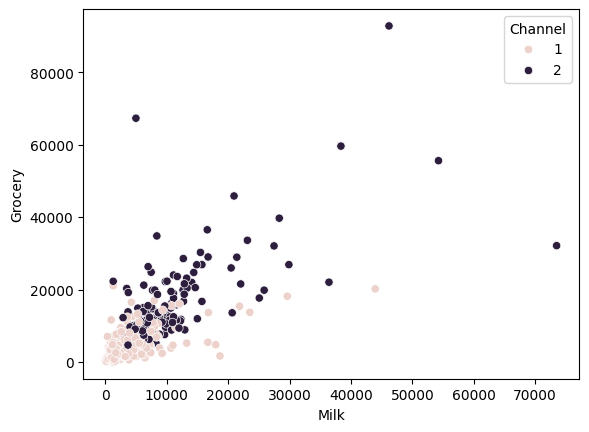

In [51]:
sns.scatterplot(data=df, x='Milk', y='Grocery', hue='Channel')

Мы видим, что для канала 1 расходы заметно меньше, чем для канала 2.

Построим гистограммы для колонки MILK и раскрасим цветами по колонке Channel. Расположим этот график по вертикали, чтобы 1 график располагался над другим (multiple='steck').

<Axes: xlabel='Milk', ylabel='Count'>

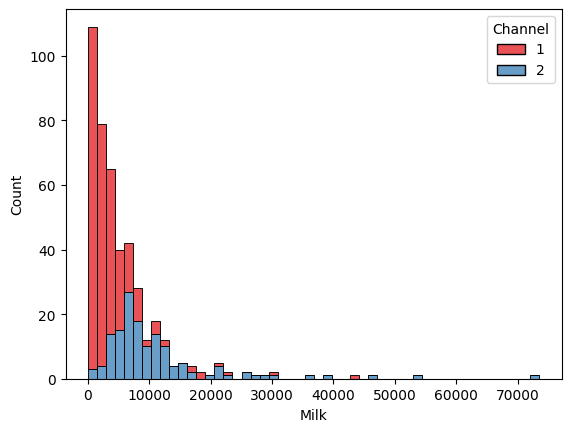

In [52]:
sns.histplot(data=df, x='Milk', hue='Channel', palette='Set1', multiple='stack')

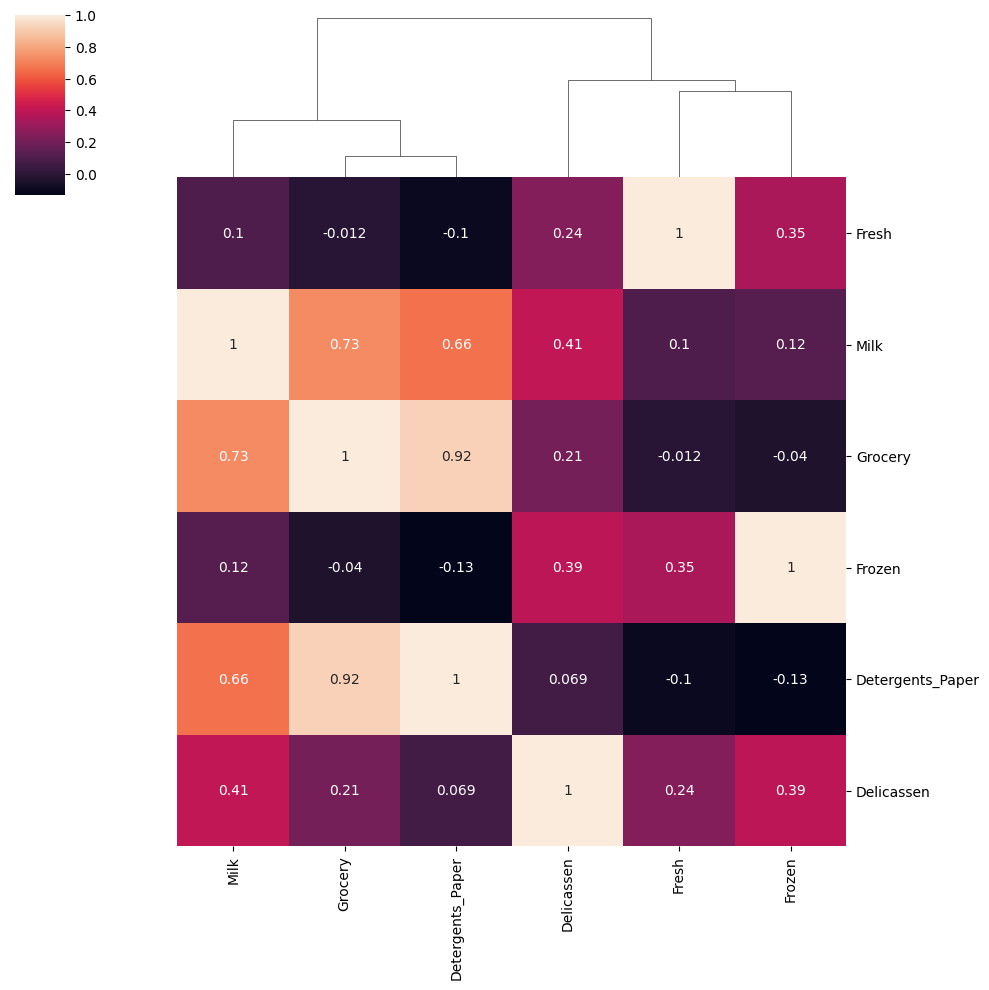

In [53]:
sns.clustermap(df.drop(['Region', 'Channel'], axis=1).corr(), annot=True, row_cluster=False)

Мы получили карту корреляций для непрерывных колонок. Мы видим заметную корреляцию между колонками Grocery и Milk, Frozen и Detergents_paper, Frash и Frozen. Они сгуппированы в свои кластеры. 

Построим график PairPlot и раскрасим его по колонке Region

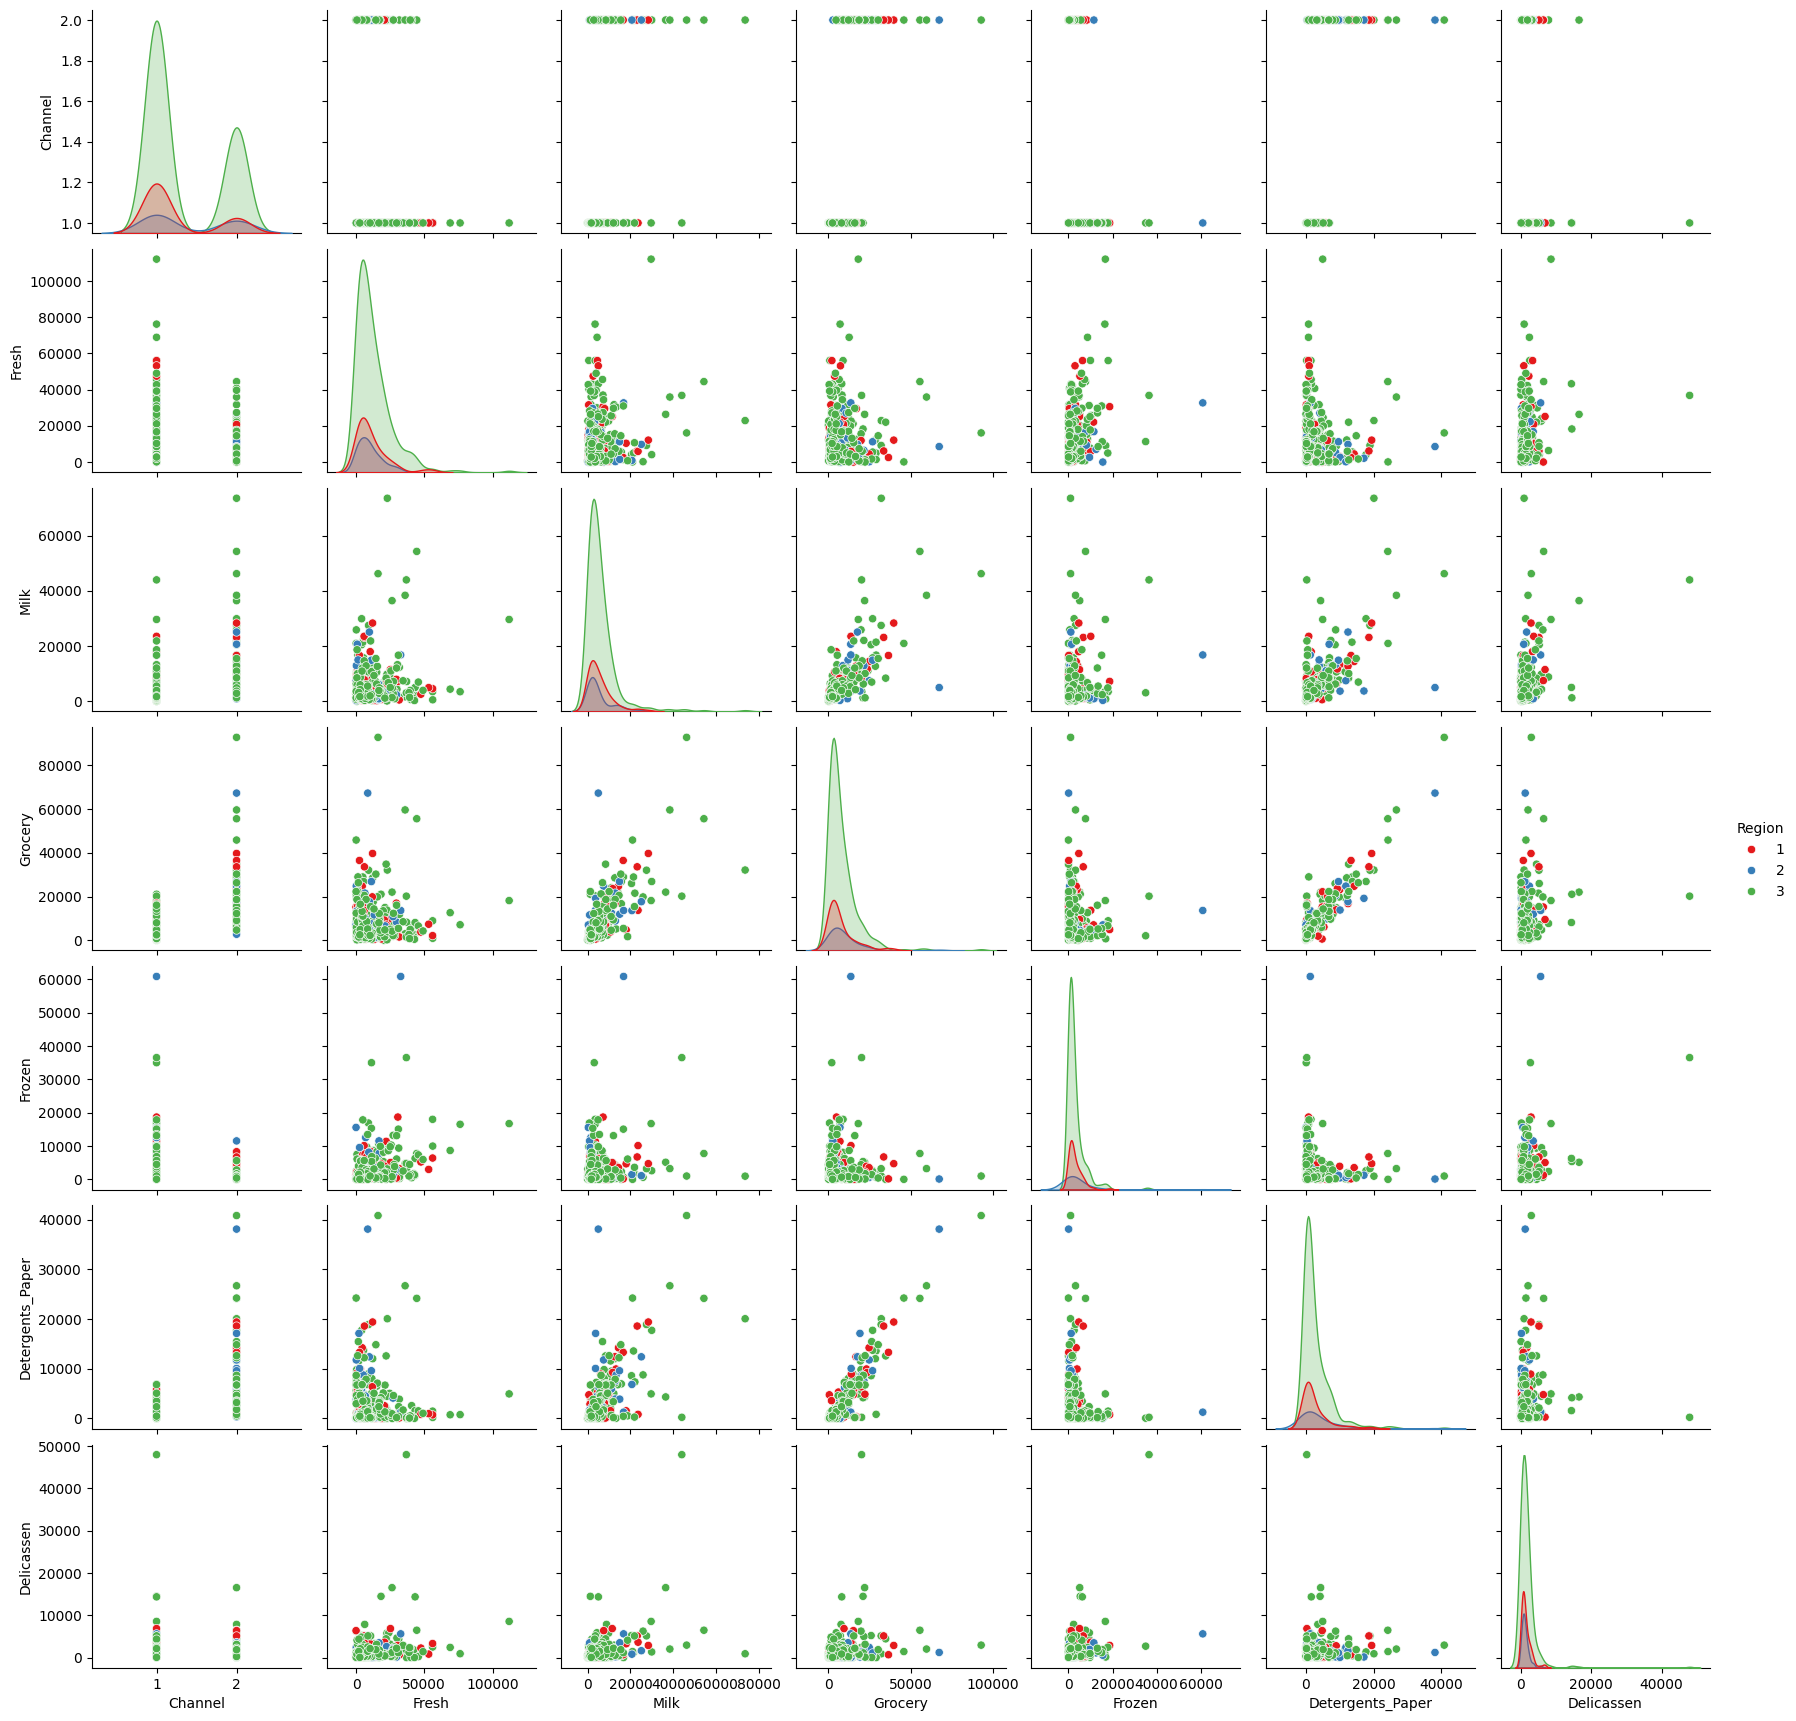

In [54]:
sns.pairplot(data=df, hue='Region', palette='Set1')

По регионам особой разницы не заметно. Посмотри по колонке Channel

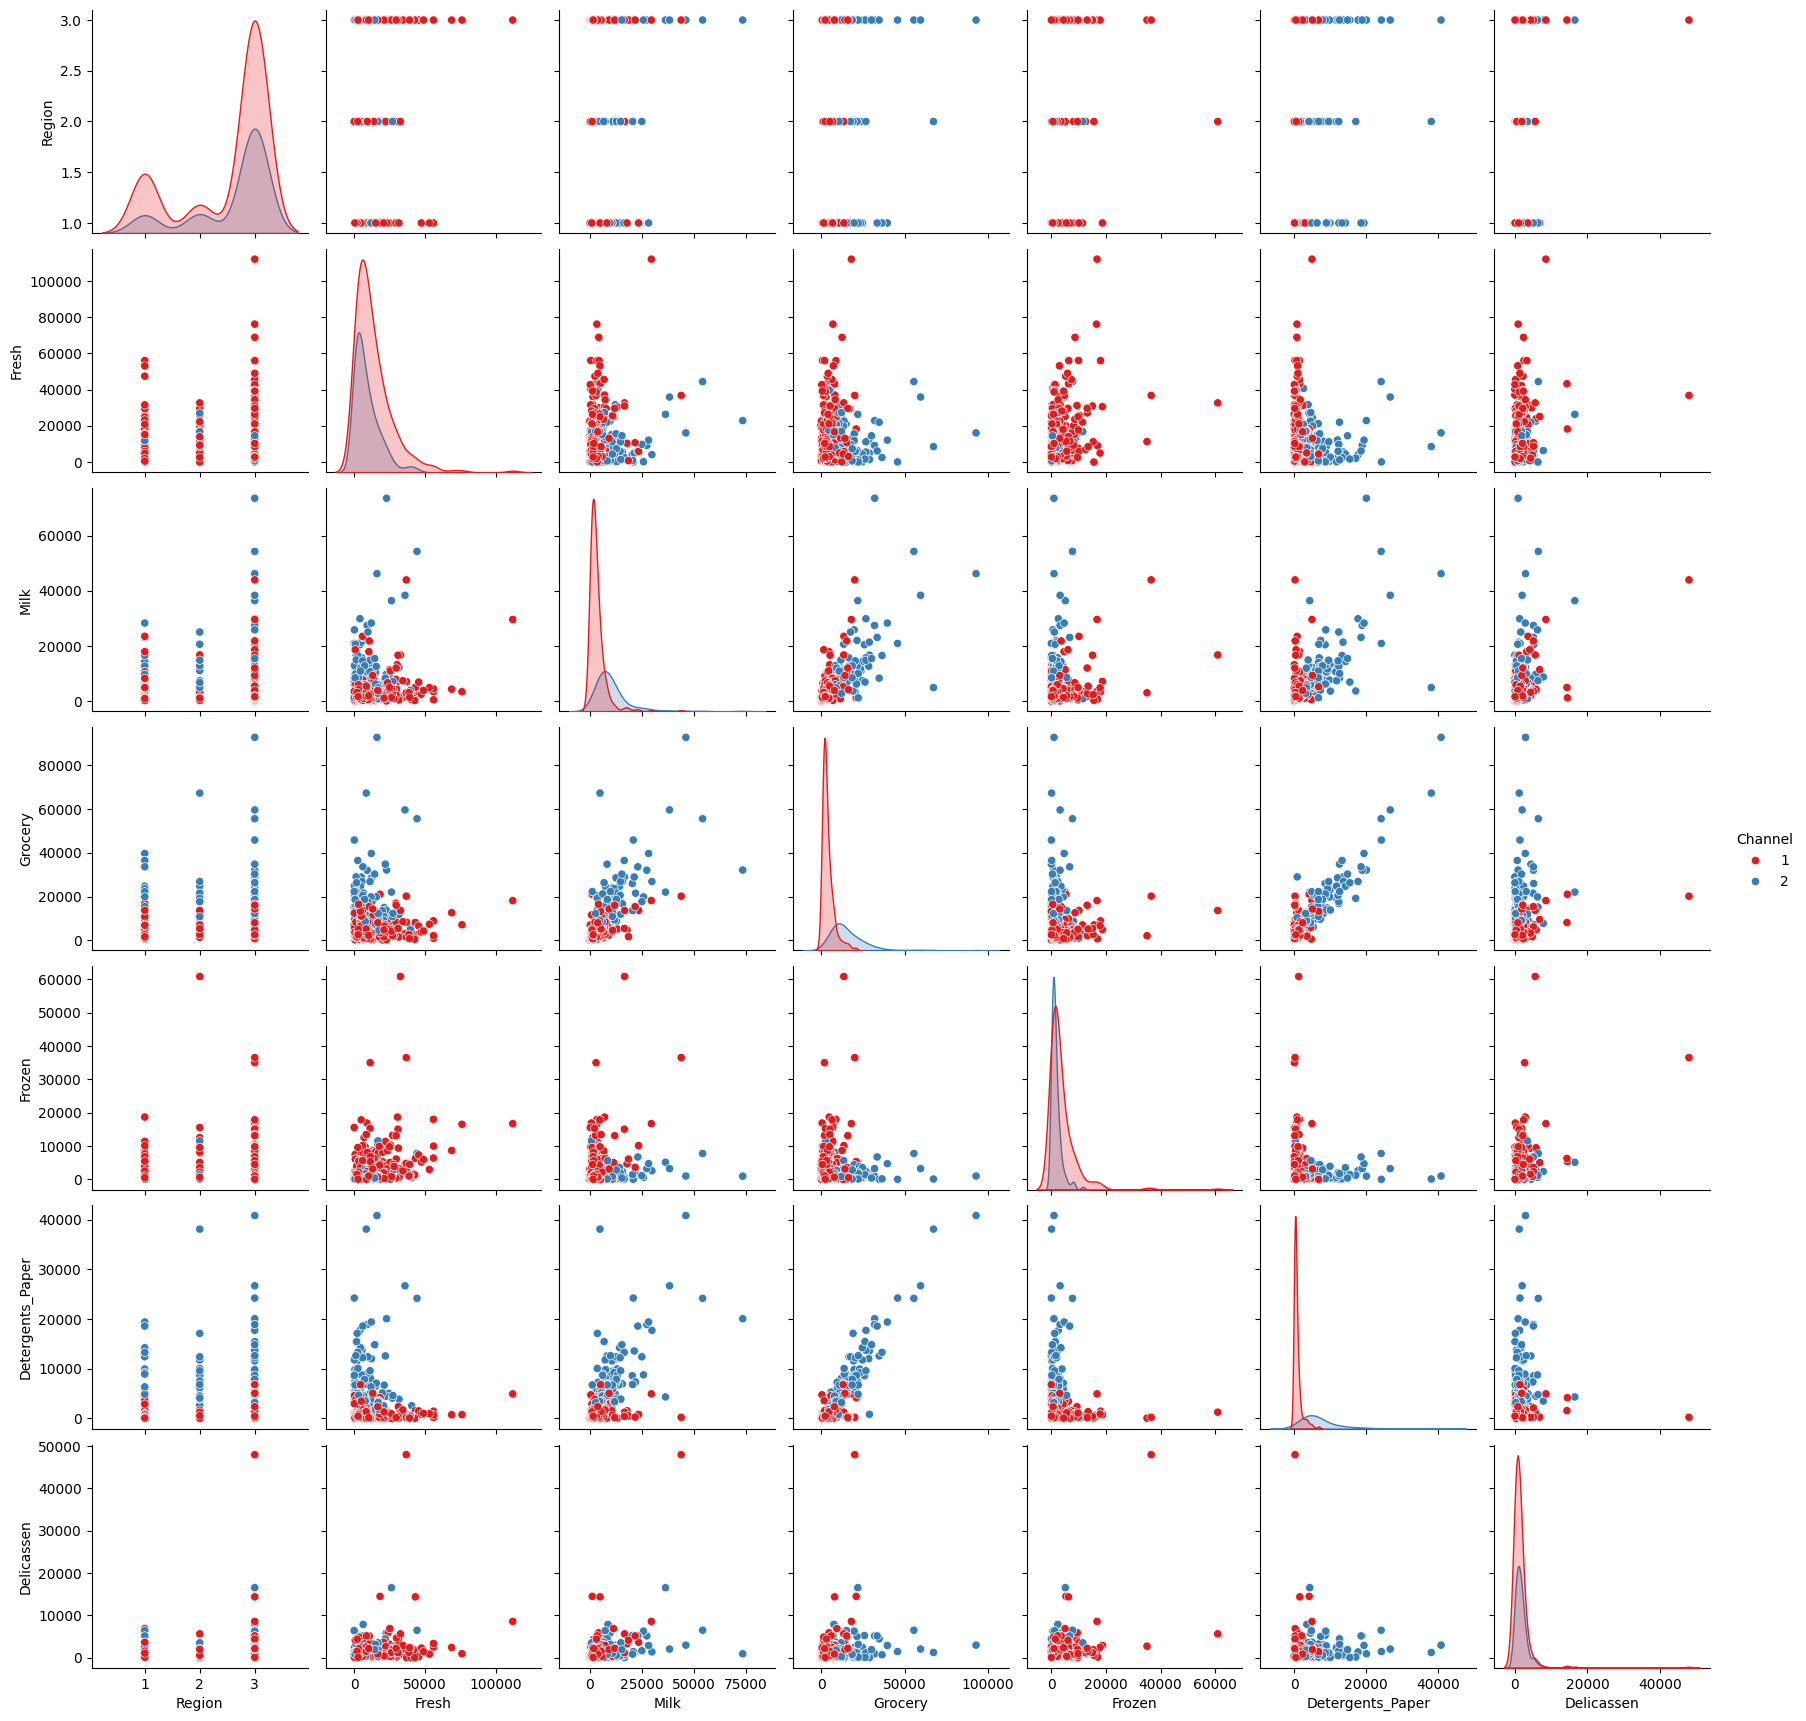

In [55]:
sns.pairplot(data=df, hue='Channel', palette='Set1')

Тут мы явно видим отдельные каналы 1 и 2. 

# выполним масштабирование данных для кластеризации

In [56]:
from sklearn.preprocessing import StandardScaler

In [57]:
scaler = StandardScaler()

In [58]:
scaled_X = scaler.fit_transform(df)

# Построим модель DBSCAN и подберем параметры

In [59]:
from sklearn.cluster import DBSCAN

In [60]:
outlier_percent = []

for eps in np.linspace(0.001, 3, 50):  # 50 равноудаленных значений eps от 0,001 до 3
    dbscan = DBSCAN(eps=eps, min_samples=2*scaled_X.shape[1])
    dbscan.fit(scaled_X)

    # процент точек-выбросов
    percent_outliers = (100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_))
    outlier_percent.append(percent_outliers)   

Построим график для процента точек-выбросов в зависимости от значений эпсилон

<Axes: >

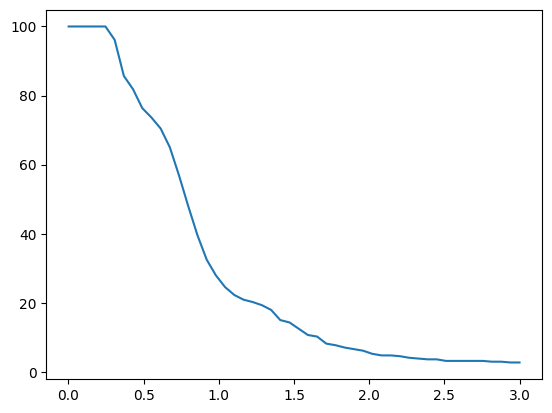

In [61]:
sns.lineplot(x=np.linspace(0.001, 3, 50), y=outlier_percent)

Если мы посмотрим на график (sns.scatterplot(data=df, x='MILK', y='Grocery', hue='Channel')), то мы можем увидеть некоторые выбросы, 5-15 точек.

Найдем такую точку по графику lineplot. Допустим это эпсилон = 2. 

In [62]:
dbscan = DBSCAN(eps=2, min_samples=2*scaled_X.shape[1])
dbscan.fit(scaled_X)

DBSCAN(eps=2, min_samples=16)

Построим график для колонок Milk и Grocery. Раскрасим цветами по результатам рабты модели DBSCAN

<Axes: xlabel='Grocery', ylabel='Milk'>

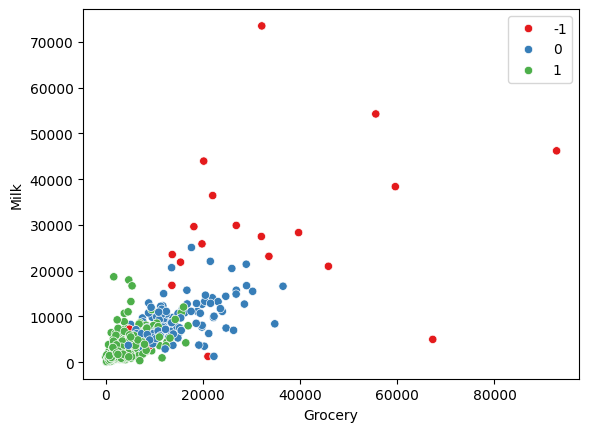

In [63]:
sns.scatterplot(data=df, x='Grocery', y='Milk', hue=dbscan.labels_, palette='Set1')

Мы видим кластер -1. Многие точки явно находятся вдалеке от скопления. При этом рядом со скоплением тоже есть точки-выбросы. 

Построим график для колонок Milk и Detergents_paper. Раскрасим цветами по результатам рабты модели DBSCAN

<Axes: xlabel='Detergents_Paper', ylabel='Milk'>

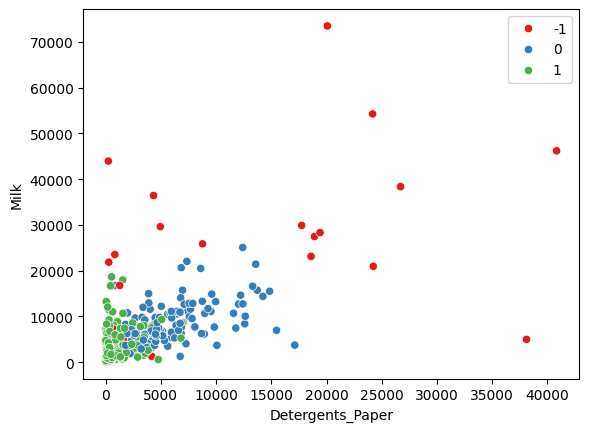

In [64]:
sns.scatterplot(data=df, x='Detergents_Paper', y='Milk', hue=dbscan.labels_, palette='Set1')

Здесь мы тоже видим выбросы рябом со скоплением.

Создадим новую колонку с результатами работы модели DBSCAN

In [65]:
df['Labels'] = dbscan.labels_

In [66]:
df.head(2)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0


Вычислим средние значения расходов по различным категориям, причем отдельно для каждого из кластеров (включая выбросы). Сравним расходы между собой по отдельным категориям. Нам нужны колонки с непрерывными значениями. Удалим категориальные.

In [67]:
cats = df.drop(['Channel', 'Region'], axis=1)

In [68]:
cats_means = cats.groupby('Labels').mean()

In [69]:
cats_means

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,27729.920000,22966.960000,26609.600000,11289.640000,11173.560000,6707.160000
0,8227.666667,8615.852713,13859.674419,1447.759690,5969.581395,1498.457364
1,12326.972028,3023.559441,3655.328671,3086.181818,763.783217,1083.786713


<Axes: ylabel='Labels'>

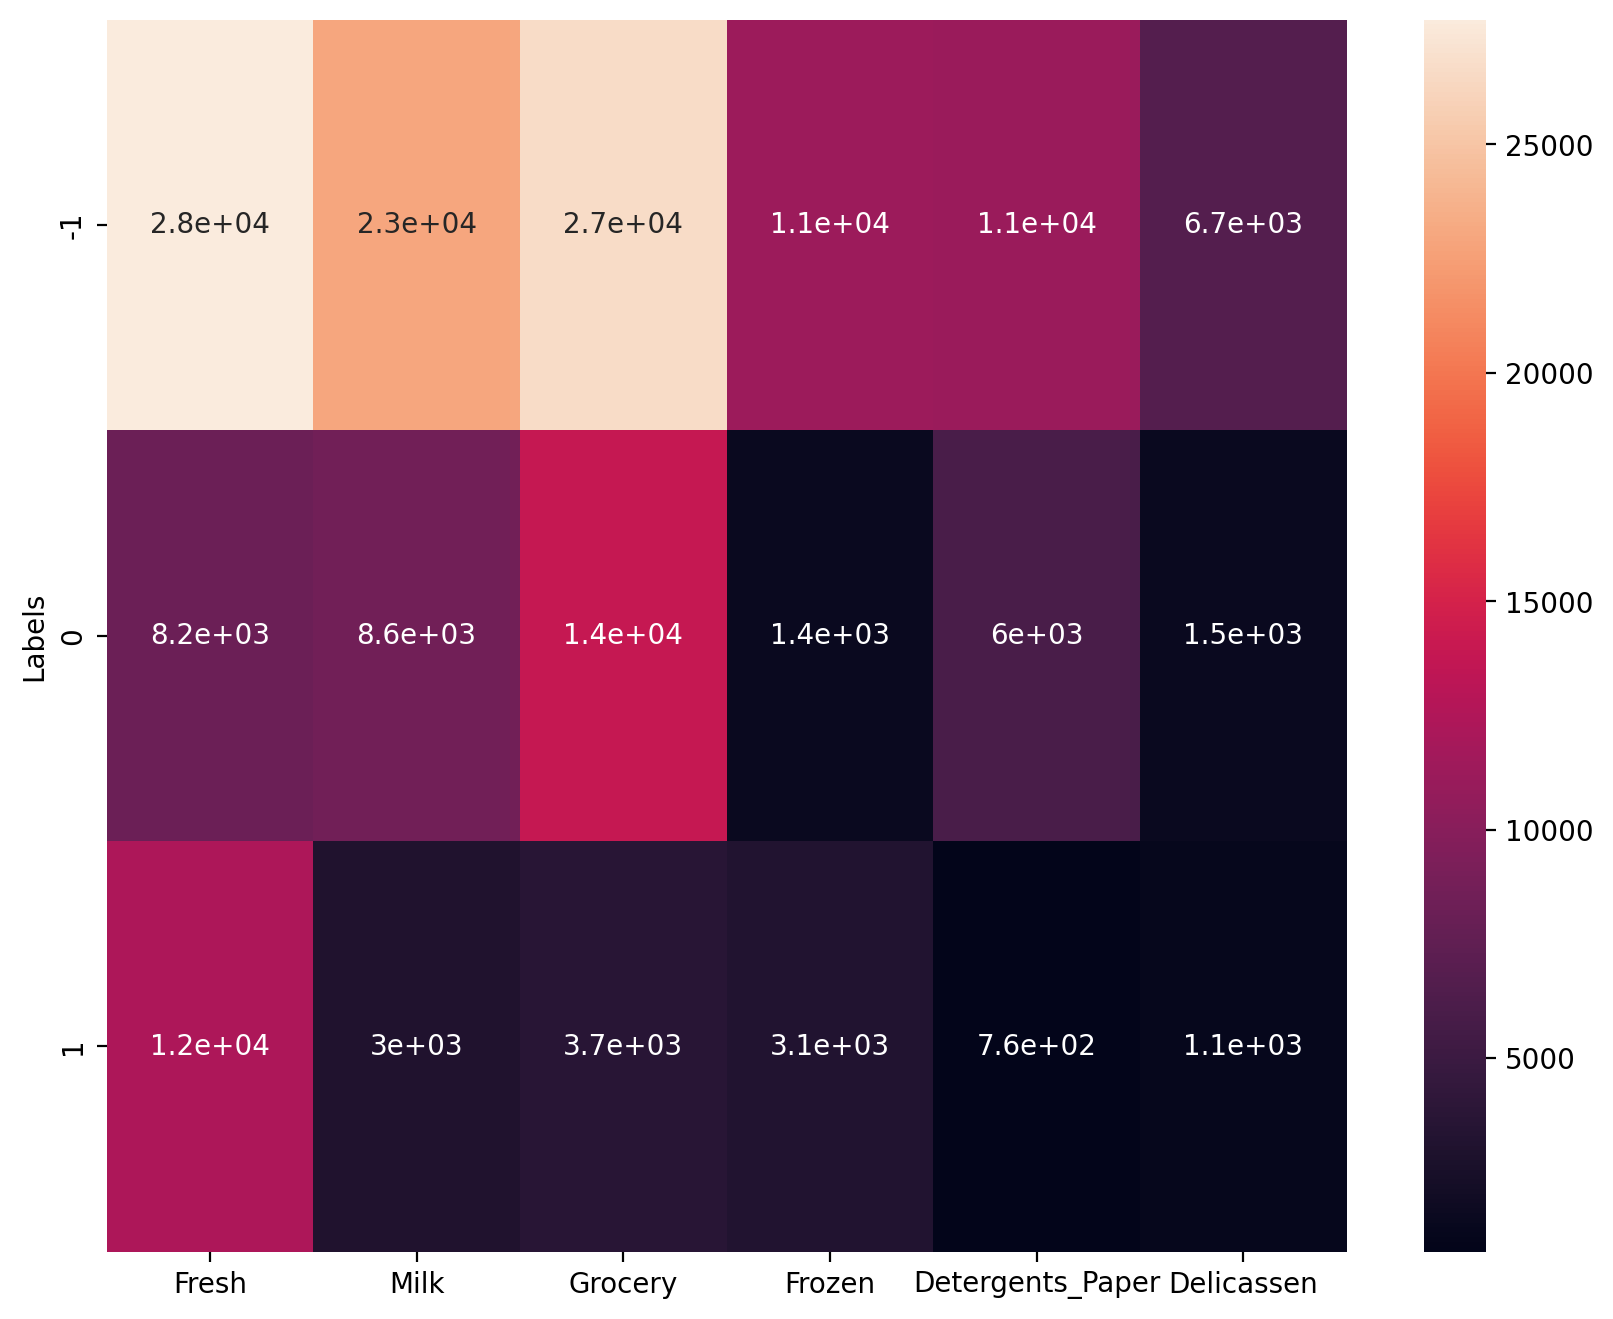

In [70]:
plt.figure(figsize=(10, 8), dpi=200)
sns.heatmap(cats_means, annot=True)

На этой карте светлый цвет - это большие значения колонок. Выбросы имеют колонки fresh, milk и grocery. Уберем выбросы (-1) и посмотрим на класетры 0 и 1. 

<Axes: ylabel='Labels'>

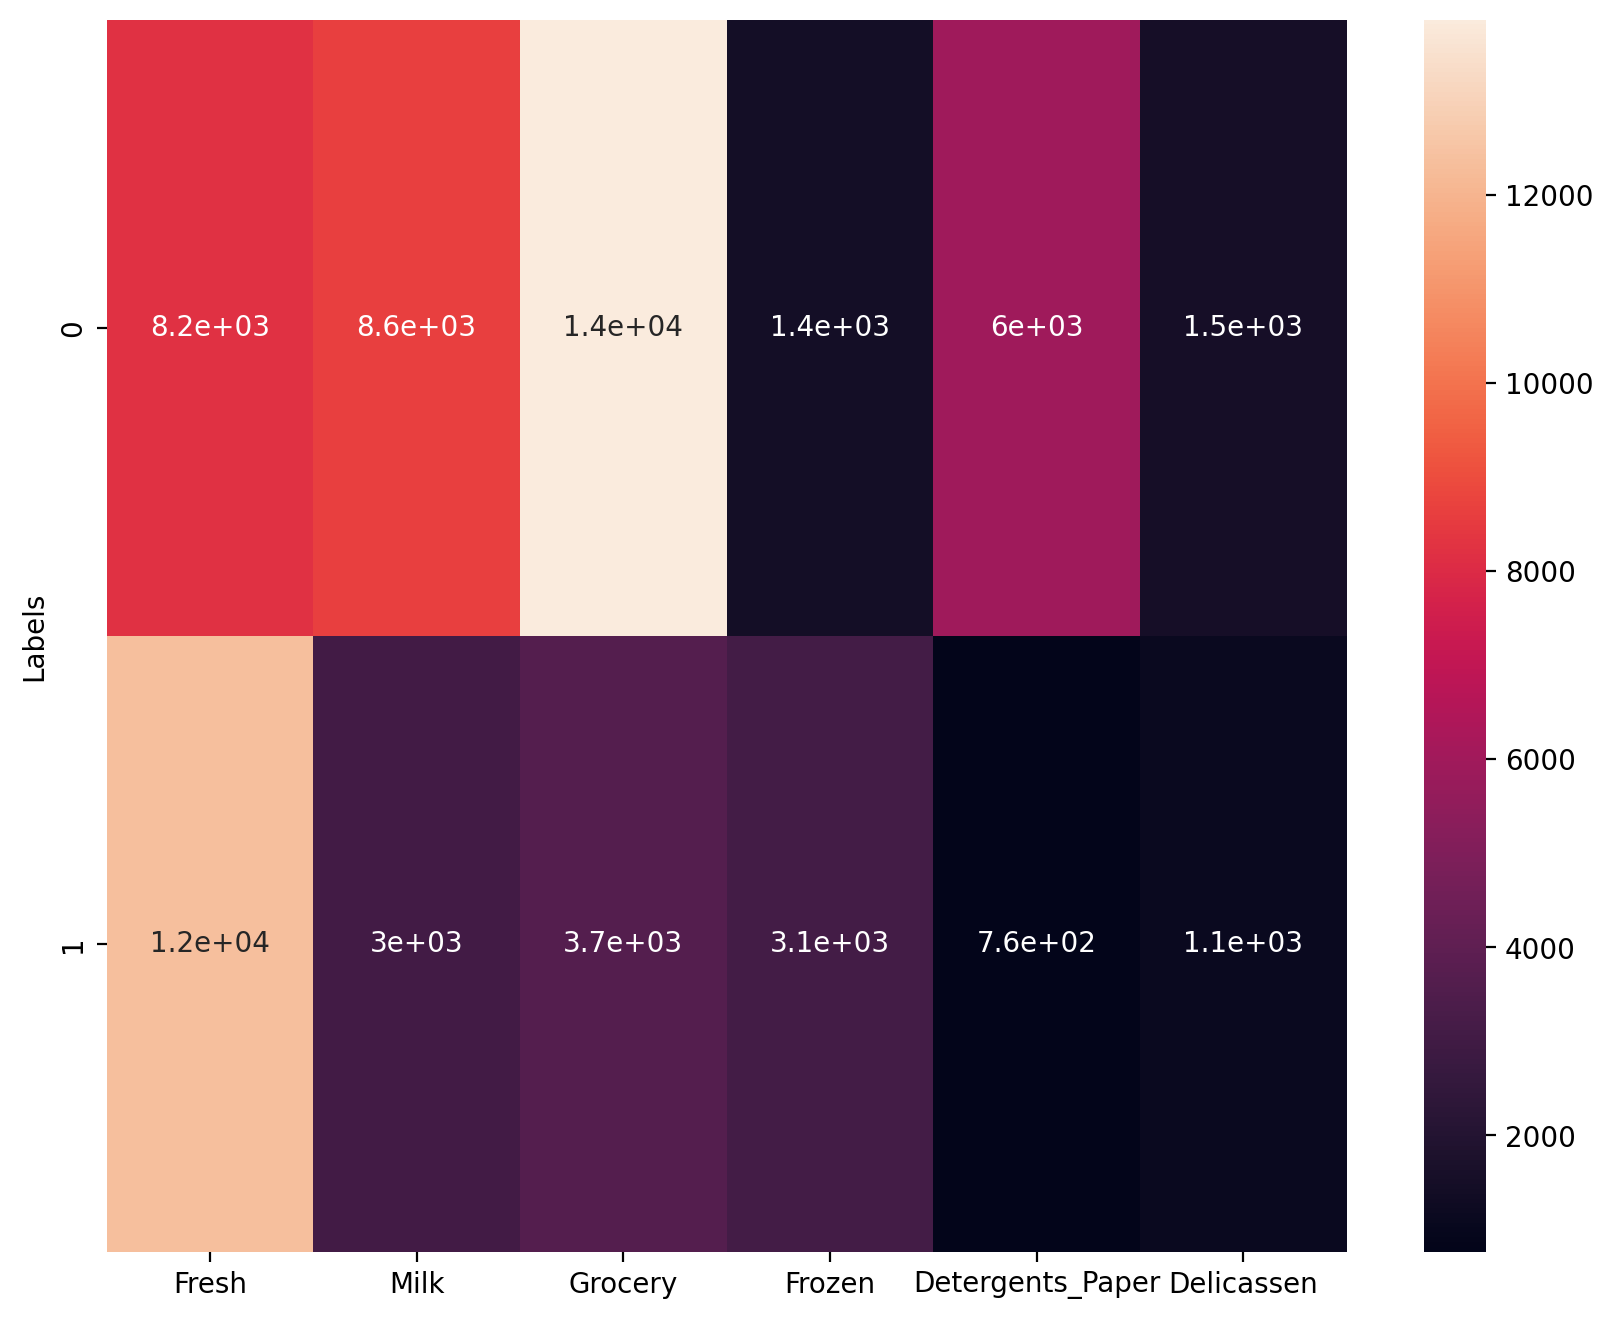

In [71]:
plt.figure(figsize=(10, 8), dpi=200)
sns.heatmap(cats_means.loc[[0, 1]], annot=True)

Мы получили тепловую карту для кластеров 0 и 1. Мы видим, что в кластере 0 в среднем клиенты тратят больше в колонках Milk, Grocery и Detergents_paper, чем в кластере 1. И наобором, в категориях frash и Frozen клиенты в кластере 0 среднем тратят меньше. В категории Delicatessen клиенты в обоих кластерах в среднем тратят примерно одинаково. 

Выполним нормализацию таблицы с данными, чтобы категориальные признаки менялись в диапазоне от 0 до 1. 

In [72]:
from sklearn.preprocessing import MinMaxScaler

In [73]:
scaler = MinMaxScaler()
scaled_cat_data = scaler.fit_transform(cats_means)

In [74]:
scaled_cat_data

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.        , 0.28040821, 0.44455106, 0.        , 0.5000874 ,
        0.07374055],
       [0.2101965 , 0.        , 0.        , 0.1664745 , 0.        ,
        0.        ]])

выбросы - это максимальные значения по всем колонкам. Преобразуем массив numpy в Датафрейм

In [75]:
pd.DataFrame(scaled_cat_data, cats_means.index, cats_means.columns)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,0.000000,0.280408,0.444551,0.000000,0.500087,0.073741
1,0.210196,0.000000,0.000000,0.166475,0.000000,0.000000


Мы видим, что кластер -1 тратит больше всех по всем колонкам. А также, кластер 1 тратит меньше всех по колонками Milk, Delicatessen, Detergents_paper и Grocery.

<Axes: ylabel='Labels'>

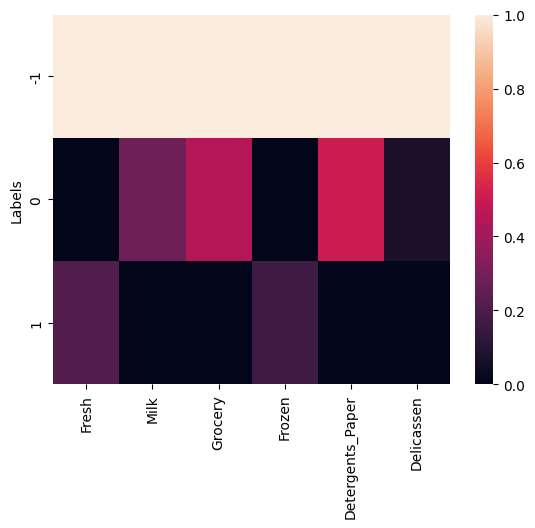

In [76]:
sns.heatmap(pd.DataFrame(scaled_cat_data, cats_means.index, cats_means.columns))

Построим такое для 2 кластеров

<Axes: ylabel='Labels'>

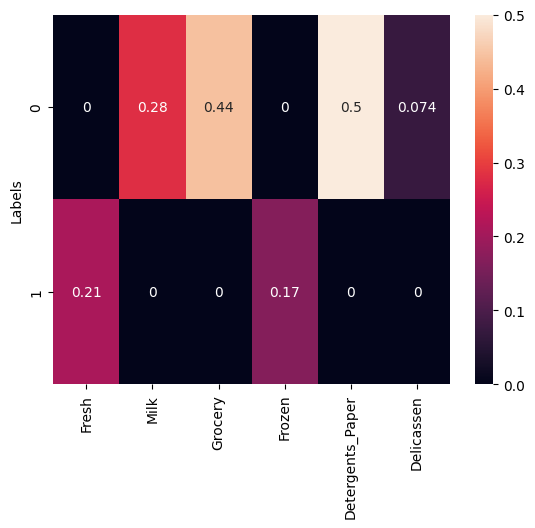

In [77]:
sns.heatmap(pd.DataFrame(scaled_cat_data, cats_means.index, cats_means.columns).loc[[0, 1]], annot=True)

Мы видим, что по категории Detergents_paper и Milk расходы различаются наиболее заметно.